In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
import math
import statistics
import cmath

In [2]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,8)})

In [3]:
#0<gamma_L<gamma_H<1
gamma_L = 0.3
gamma_H = 0.45
fixed_cost = 0.45
sigma = 1.5
beta = 0.95
delta = 0.08
theta = 0.8
#front = []

In [4]:
#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
def Edge_Weight(node1,node2, b, a):
        try:
             weight = 1+math.exp(a*((node1.k-node2.k)-b))
        except OverflowError:
             weight = float('inf')
        return 1/weight  

In [8]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        
        super().__init__(unique_id, model)
        self.k = money[unique_id] #initial stock of wealth
        self.lamda = round(random.uniform(0.1,1),1) #saving propensity
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)    
        self.alpha = alpha[unique_id]#human capital 
        self.tec = 'NA'
        self.income = 0 #initialising income
        self.income_generation() #finding income corresponding to the human capital,
                                 #needed here to set the initial consumption
        self.front = 0 #for micawber frontier
        self.consum = random.uniform(0,self.income) #generating consumption such that it is lower than income
        while(self.consum > self.income):
            self.consum = random.uniform(0,self.income)
        #self.consum = self.consum/100  #making consumption further smaller
        self.model.agents.append(self)
        
        
    #function that decides income based on the type of technology
    def income_generation(self): 
        b1 = pow(self.k,gamma_H)
        H = self.alpha*b1 - fixed_cost
        
        b2 = pow(self.k,gamma_L)
        L = self.alpha*b2
        
        self.front = H
        if(H>=L): #
            self.income = H
            self.tec = 'H'
        else:
            self.income = L
            self.tec = 'L'
            
    
    #function that updates the capital and consumption for the next time step    
    def income_updation(self):
        
        #finding expected value of income at each time step
        e_t = [a.income for a in self.model.agents] #is this k or f(alpha,k)?
        E_t = statistics.mean(e_t)
        k = self.k
        alpha = self.alpha
        consum = self.consum
        print("Mean:", E_t)
        print("Agent:{}  Tec: {}".format(self.unique_id, self.tec))
        print("Old C:", self.consum)
        print("Old k = {}, alpha = {} " .format(k, alpha))
       
         #normal calculation that is giving nan values in the presence of negative k
        if(self.tec == 'H'):
            
            #k_t^gamma
            a1 = pow(k,gamma_H) 
            print("a1 = ", a1)
           
            #k_t+1 = theta*(alpha*k_t^gamma - C_t + (1-delta)*k_t)
            k_new = theta*(alpha*a1-consum + (1-delta)*k)
            self.k = k_new
            print("New k : ", k_new)
            
            #k_t+1^(gamma-1)
            a2 = pow(k_new,(gamma_H-1)) 
            print("a2 = ",a2)
            
            #long form of solving
            
            #beta*E*theta*(alpha*gamma*k_t+1^(gamma-1)+(1-delta))
            #e1 = beta*E_t*theta*(alpha*gamma_H*a2 + (1-delta)) 
            
            #c^(-sigma)
            #e2 = pow(consum,-sigma) 
            
            #c^(-sigma)/beta*E*theta*(alpha*gamma*k_t+t^(gamma-1)+(1-delta))
            #e3 = e2/e1     
            #p = -(1/sigma)
            #self.consum =  pow(e3,p)
            
            #short form of solving
            
            #beta*E*theta*(alpha*gamma*k_t+1^(gamma-1)+(1-delta))
            e1 = beta*E_t*theta*(alpha*gamma_H*a2 + (1-delta)) 
            
            #(beta*E_t*theta*(alpha*gamma_H*a2 + (1-delta)))^(1/sigma)
            e2 = pow(e1, (1/sigma))
            self.consum = consum * e2
            
            print("e1",e1)
            print("e2",e2)
            #print("e3",e3)
            print("New Consum :", self.consum)     

        if(self.tec == 'L'):
            
            #k_t^gamma
            a1 = pow(k,gamma_L)  
            print("a1 = ", a1)
           
            #k_t+1 = theta*(alpha*k_t^gamma - C_t + (1-delta)*k_t)
            k_new = theta*(alpha*a1-consum + (1-delta)*k)
            self.k = k_new
            print("New k : ", k_new)
            
            #k_t+1^(gamma-1)
            a2 = pow(k_new,(gamma_L-1)) 
            print("a2 = ",a2)
            
            #long form of the solution
           
            #beta*E*theta*(alpha*gamma*k_t+1^(gamma-1)+(1-delta))
            #e1 = beta*E_t*theta*((alpha*gamma_L*a2) + (1-delta))
            
            #c^(-sigma)
            #e2 = pow(consum,-sigma) 
            
            #e2 = pow(e1, (1/sigma))
            #self.consum = consum * e2
            
            #c^(-sigma)/beta*E*theta*(alpha*gamma*k_t+t^(gamma-1)+(1-delta))
            #e3 = e2/e1     
            #p = -(1/sigma)
            #self.consum = pow(e3,p)
            
            #short form of solving
            
            #beta*E*theta*(alpha*gamma*k_t+1^(gamma-1)+(1-delta))
            e1 = beta*E_t*theta*(alpha*gamma_L*a2 + (1-delta)) 
            
            #(beta*E_t*theta*(alpha*gamma_L*a2 + (1-delta)))^(1/sigma)
            e2 = pow(e1, (1/sigma))
            self.consum = consum * e2
            
            print("e1",e1)
            print("e2",e2)
            #print("e3",e3)
            print("New Consum :", self.consum)
    
    #finding neighbor nodes for the purpose of making an edge/connection
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in self.model.agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
    
     #function used to trade/communicate     
    def give_money(self): 
        b = self.model.b
        a = self.model.a
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            if(w >= random.random()): 
                xi = self.income
                xj = other.income
                delta_income = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_income
                xj_new = xj + delta_income
                other.income = xj_new
                self.income = xi_new
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor,b, a)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor,b, a)
        
   
    #link addition happening at every time step
    def Local_Attachment(self): 
        b = self.model.b
        a = self.model.a
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        count = 0 #to avoid an infinite loop when all agents have already made links with each other
        while(self.model.G.has_edge(node1,node2)==True and count <5):
            node2 = random.choice(self.model.nodes)
            node1 = random.choice(self.model.nodes)
            count +=1
        for agent in self.model.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, b, a))
    
   #links are deleted randomly at every time step
   def Link_Deletion(self):
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==False):
            node1 = random.choice(self.model.nodes)
            node2 = random.choice(self.model.nodes)
        self.model.G.remove_edge(node1,node2)
                    
    def step(self):
        #if(self.k > 0):
        self.income_updation()
        self.give_money()
        self.Local_Attachment()
        self.Link_Deletion()
        self.income_generation() 
    

In [9]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,b, a,N=500): #N- number of agents

        self.N = N
        self.b =b
        self.a = a
        self.agents = []
        self.gini = 0
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        self.nodes = np.linspace(0,N-1,N, dtype = 'int') #to keep track of the N nodes   
        
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {"Gini": 'gini'},agent_reporters={"k_t":'k','income':'income',
                                           'H':'front', 'consumption':'consum','lamda':'lamda','alpha':'alpha', 'technology':'tec' })       
        for i, node in enumerate(self.G.nodes()):
            agent = MoneyAgent(i, self)
            self.schedule.add(agent)
           
        self.running = True
        self.datacollector.collect(self)
        
    def Global_Attachment(self):
        #print("Global Attachment no: {}".format(self.count))
        node1 = random.choice(self.nodes)
        node2 = random.choice(self.nodes)
        while(self.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.nodes)
            node1 = random.choice(self.nodes)
        #adding the edge node1-node2
        for agent in self.agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a, self.b, self.a))
        
    def compute_gini(self):
        agent_wealths = [agent.k for agent in self.schedule.agents]
        x = sorted(agent_wealths)
        B = sum(xi * (self.N - i) for i, xi in enumerate(x)) / (self.N * sum(x))
        return 1 + (1 / self.N) - 2 * B
    
    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.step()
            self.Global_Attachment()
            self.gini = self.compute_gini()

In [10]:
N = 100
steps = 50
b = 35
a = 0.69
alpha = np.random.normal(loc = 1.08, scale = 0.074, size = N) 
money = np.random.uniform(low = 0.1, high = 10, size = N)
model = BoltzmannWealthModelNetwork(b, a,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Mean: 1.6941261233838845
Agent:54  Tec: L
Old C: 0.09946435345657216
Old k = 1.4186864309660612, alpha = 1.1041246790880679 
a1 =  1.1106211111934456
New k :  1.9455930728136808
a2 =  0.6275720482478396
e1 1.4521799335726997
e2 0.7798056529113677
New Consum : 0.12755018264515866
Mean: 1.6953448420560664
Agent:70  Tec: H
Old C: 0.46570479414215005
Old k = 7.235248123607661, alpha = 1.0611301282133407 
a1 =  2.436430587971219
New k :  7.020874705418963
a2 =  0.34236142670810377
e1 1.3960235529026832
e2 0.8005801841841144
New Consum : 0.5817091196389755
Mean: 1.6949972804798188
Agent:32  Tec: H
Old C: 0.8599654520153581
Old k = 7.320220260246982, alpha = 1.0092026958363258 
a1 =  2.4492655104894676
New k :  6.677154034733417
a2 =  0.35194494575058394
e1 1.3910382582510419
e2 0.8024918248507749
New Consum : 1.0716189565859697
Mean: 1.693995395553432
Agent:10  Tec: L
Old C: 0.27613103931701466
Old k = 3.8446974294125016, alpha = 1.0926068673493683 
a1 =  1.4978166369615242
New k :  3.918012

Mean: 1.6738628890006684
Agent:65  Tec: L
Old C: 1.3440459935300926
Old k = 3.878206277043637, alpha = 0.9221775931384002 
a1 =  1.5017210605878246
New k :  2.8870058356545436
a2 =  0.4760873441720672
e1 1.3379193679610912
e2 0.8235943770060009
New Consum : 1.6319271124896224
Mean: 1.6668444526648634
Agent:3  Tec: H
Old C: 1.5134643124878375
Old k = 6.01318158731135, alpha = 0.9661773533878816 
a1 =  2.241800406259038
New k :  4.947711624945472
a2 =  0.41502818539906383
e1 1.3940467979109419
e2 0.801336819281479
New Consum : 1.8886743702166209
Mean: 1.6605121729415528
Agent:27  Tec: L
Old C: 0.12626301047939342
Old k = 0.2929305875157876, alpha = 0.9650175357111639 
a1 =  0.6918778334463364
New k :  0.6487258975045551
a2 =  1.3538081838652953
e1 1.655647352713476
e2 0.7145316008391273
New Consum : 0.17670738471344505
Mean: 1.6623107011716316
Agent:92  Tec: L
Old C: 0.14481953263521452
Old k = 0.9587941048811097, alpha = 1.0371247737491802 
a1 =  0.9874556669301771
New k :  1.4091086232

Mean: 1.5833079186060848
Agent:89  Tec: H
Old C: 1.8091794436447362
Old k = 5.6789712267525445, alpha = 1.211355633394833 
a1 =  2.1848486150668114
New k :  4.849682210354949
a2 =  0.4196214647336355
e1 1.3822947903796567
e2 0.8058722833203438
New Consum : 2.244995244396023
Mean: 1.5839198158834118
Agent:27  Tec: L
Old C: 0.17670738471344505
Old k = 0.6487258975045551, alpha = 0.9650175357111639 
a1 =  0.8782504291270256
New k :  1.0141180046753442
a2 =  0.9902345035088291
e1 1.4525738267463888
e2 0.7796646737282744
New Consum : 0.22664536520354184
Mean: 1.5851353925960459
Agent:65  Tec: L
Old C: 1.6319271124896224
Old k = 2.8870058356545436, alpha = 0.9221775931384002 
a1 =  1.374466940906031
New k :  1.8332966973804652
a2 =  0.654239966162227
e1 1.3263750374073928
e2 0.8283663338325367
New Consum : 1.9700548487277543
Mean: 1.5804655165792199
Agent:7  Tec: L
Old C: 0.5898704652917754
Old k = 1.179562392689753, alpha = 0.9333875443734844 
a1 =  1.0507908328431677
New k :  1.18089760888

New k :  4.999490039604954
a2 =  0.4126585624149844
e1 1.391904241483616
e2 0.8021589396207902
New Consum : 4.334885286719351
Mean: 1.5945879755635317
Agent:87  Tec: H
Old C: 0.9316873813161517
Old k = 4.722778740886345, alpha = 1.135480726362277 
a1 =  2.010892803298963
New k :  4.557279264980695
a2 =  0.434222073276488
e1 1.3838207138196048
e2 0.8052797568939529
New Consum : 1.1569735527809193
Mean: 1.5942243770082123
Agent:13  Tec: H
Old C: 1.2837883606324714
Old k = 5.394281087102567, alpha = 1.0217036972225908 
a1 =  2.1348634792538106
New k :  4.688118519456795
a2 =  0.4275144314595104
e1 1.3528320739467068
e2 0.8175307040730337
New Consum : 1.5703243367331494
Mean: 1.593153838195368
Agent:25  Tec: H
Old C: 1.9672855611548146
Old k = 5.662180434550421, alpha = 1.003971542692298 
a1 =  2.181939312456464
New k :  4.346020332975569
a2 =  0.4457070825968254
e1 1.3577449849330545
e2 0.8155573920793173
New Consum : 2.4121975721893594
Mean: 1.5851262634728547
Agent:61  Tec: L
Old C: 0.6

Mean: 1.5663659276701185
Agent:22  Tec: L
Old C: 0.4771659585233226
Old k = 2.15589065729796, alpha = 1.0829935218025728 
a1 =  1.2591805860376508
New k :  2.295950290919315
a2 =  0.5588899025331912
e1 1.3113654780733235
e2 0.8346751853889446
New Consum : 0.5716786204695559
Mean: 1.5715224411396893
Agent:57  Tec: H
Old C: 0.9499493216759202
Old k = 7.204503371341193, alpha = 1.0095643733953468 
a1 =  2.4317662238770286
New k :  6.506574659208288
a2 =  0.3569900982971456
e1 1.2925117285230074
e2 0.8427724655705764
New Consum : 1.1271717580768168
Mean: 1.584344873451774
Agent:97  Tec: H
Old C: 0.356318361606485
Old k = 5.8639972352117, alpha = 1.0354281434264496 
a1 =  2.2165992940910857
New k :  5.866950709271514
a2 =  0.3778967511775503
e1 1.3197900896520023
e2 0.8311194095547844
New Consum : 0.4287210207223512
Mean: 1.5856667819813683
Agent:23  Tec: L
Old C: 0.35338973567147164
Old k = 1.3446675517087492, alpha = 0.9895413167049989 
a1 =  1.0929101957277336
New k :  1.572147364817054


C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


 2.2096978005878634
New k :  5.801468114813353
a2 =  0.3802368029004653
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:87  Tec: H
Old C: 1.1569735527809193
Old k = 4.557279264980695, alpha = 1.135480726362277 
a1 =  1.9788712509398667
New k :  4.226154829116758
a2 =  0.4526161309944083
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:94  Tec: L
Old C: 2.064640400261881
Old k = 2.5388555466252014, alpha = 1.0607172420893038 
a1 =  1.322486956827304
New k :  1.339113136142591
a2 =  0.815131939973494
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: H
Old C: 0.35996126024537234
Old k = 6.996002888325669, alpha = 0.9550988612612379 
a1 =  2.3998411232205377
New k :  6.694757536808055
a2 =  0.35143566315384817
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: H
Old C: 2.2659622131769432
Old k = 5.743221262335155, alpha = 1.0740929082291537 
a1 =  2.1959376084741264
New k :  4.301153888277717
a2 =  0.4482582180443688
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:82  Tec: L
Old C: 

New k :  5.065715816731487
a2 =  0.4096826269690732
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: H
Old C: 2.578003794594223
Old k = 5.909268285172459, alpha = 0.9312587902697801 
a1 =  2.2242836447473446
New k :  3.943925379190967
a2 =  0.470153010002162
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: 2.355550468504977
Old k = 4.108268662658612, alpha = 1.0169541607046204 
a1 =  1.5279095698212002
New k :  2.382296556280818
a2 =  0.5446317104285863
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:22  Tec: L
Old C: 0.5716786204695559
Old k = 2.295950290919315, alpha = 1.0829935218025728 
a1 =  1.2831834343129476
New k :  2.3442199950572107
a2 =  0.5508091471165559
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:57  Tec: H
Old C: 1.1271717580768168
Old k = 6.506574659208288, alpha = 1.0095643733953468 
a1 =  2.3227827271684838
New k :  5.763100493505755
a2 =  0.38162700064448
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:20  Tec: L
Old C: 0.8062008041543737
Old k

Mean: nan
Agent:76  Tec: L
Old C: 0.8352109535183829
Old k = 3.6734533100259186, alpha = 1.1670328283258644 
a1 =  1.477482539774009
New k :  3.414909375120004
a2 =  0.42328665046968716
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:78  Tec: L
Old C: nan
Old k = -0.08922445285153131, alpha = 1.103797260868901 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:26  Tec: L
Old C: nan
Old k = 4.098691020179331, alpha = 1.0347161523330968 
a1 =  1.5268400880653137
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:38  Tec: L
Old C: 2.214353332136185
Old k = 3.980097674307021, alpha = 1.0656684896270145 
a1 =  1.5134501440181385
New k :  2.4481381258622976
a2 =  0.5343365201739109
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: H
Old C: nan
Old k = 6.694757536808055, alpha = 0.9550988612612379 
a1 =  2.3527765546023622
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: 3.545548865288635
Old k = 0.20

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in double_scalars


 nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:97  Tec: H
Old C: 0.4287210207223512
Old k = 5.866950709271514, alpha = 1.0354281434264496 
a1 =  2.2171016123525296
New k :  5.8116184304587275
a2 =  0.37987140161395794
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = 0.4763245810074981, alpha = 0.9699660446133367 
a1 =  0.8005176250162824
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = 2.36662838947668, alpha = 0.943489587286958 
a1 =  1.2949083190388513
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: H
Old C: nan
Old k = 7.068584471130734, alpha = 1.040623754324991 
a1 =  2.4110132856779494
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:54  Tec: L
Old C: nan
Old k = 2.7988524427703108, alpha = 1.1041246790880679 
a1 =  1.361739392158524
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = 2.25

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:36  Tec: L
Old C: nan
Old k = nan, alpha = 1.1275782223744286 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:19  Tec: L
Old C: nan
Old k = nan, alpha = 1.1709129871952535 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:61  Tec: L
Old C: nan
Old k = nan, alpha = 1.0616262440574888 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: nan
Old k = -2.123569133125001, alpha = 1.1278114511340935 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:12  Tec: L
Old C: nan
Old k = -0.44006397543061

Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = -1.6732172681615562, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:6  Tec: L
Old C: nan
Old k = nan, alpha = 1.182312158862043 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:80  Tec: L
Old C: nan
Old k = nan, alpha = 1.1710624820245594 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New 

Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:13  Tec: L
Old C: nan
Old k = nan, alpha = 1.0217036972225908 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:12  Tec: L
Old C: nan
Old k = nan, alpha = 0.9956090093888927 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:7  Tec: L
Old C: nan
Old k = nan, alpha = 0.9333875443734844 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean

New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:75  Tec: L
Old C: nan
Old k = nan, alpha = 0.9769536300151204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:64  Tec: L
Old C: nan
Old k = nan, alpha = 1.2120611339088443 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:70  Tec: L
Old C: nan
Old k = nan, alpha = 1.0611301282133407 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:18  Tec: L
Old C: nan
Old k = nan, alpha = 1.0264784220615017 
a1 =  nan
New

e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:53  Tec: L
Old C: nan
Old k = nan, alpha = 1.0514730888615094 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:87  Tec: L
Old C: nan
Old k = nan, alpha = 1.135480726362277 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:70  Tec: L
Old C: nan
Old k = nan, alpha = 1.0611301282133407 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 

Mean: nan
Agent:65  Tec: L
Old C: nan
Old k = nan, alpha = 0.9221775931384002 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:5  Tec: L
Old C: nan
Old k = nan, alpha = 1.0867147119274174 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:7  Tec: L
Old C: nan
Old k = nan, alpha = 0.9333875443734844 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:50  Tec: L
Old C: nan
Old k = nan, alpha = 1.172758555657937 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:57  Tec: L
Old C: nan
Old k = nan, alpha = 1.0095643733953468 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mea

New Consum : nan
Mean: nan
Agent:47  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239398031040459 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:55  Tec: L
Old C: nan
Old k = nan, alpha = 1.071361477500339 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:7  Tec: L
Old C: nan
Old k = nan, alpha = 0.9333875443734844 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:28  Tec: L
Old C: nan
Old k = nan, alpha = 1.0561903925743739 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:75  Tec: L
Old C: nan
Old k = nan, alpha = 0.9769536300151204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
N

e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:25  Tec: L
Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:39  Tec: L
Old C: nan
Old k = nan, alpha = 1.068220812056623 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:81  Tec: L
Old C: nan
Old k = nan, alpha = 1.1426301345997794 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 

e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:67  Tec: L
Old C: nan
Old k = nan, alpha = 1.0491810964356538 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:97  Tec: L
Old C: nan
Old k = nan, alpha = 1.0354281434264496 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:86  Tec: L
Old C: nan
Old k = nan, alpha = 0.9780746420319208 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:94  Tec: L
Old C: nan
Old k = nan, alpha = 1.0607172420893038 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e

e2 nan
New Consum : nan
Mean: nan
Agent:28  Tec: L
Old C: nan
Old k = nan, alpha = 1.0561903925743739 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:98  Tec: L
Old C: nan
Old k = nan, alpha = 1.1233728827110665 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:86  Tec: L
Old C: nan
Old k = nan, alpha = 0.9780746420319208 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:5  Tec: L
Old C: nan
Old k = nan, alpha = 1.0867147119274174 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan


e2 nan
New Consum : nan
Mean: nan
Agent:25  Tec: L
Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:97  Tec: L
Old C: nan
Old k = nan, alpha = 1.0354281434264496 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:64  Tec: L
Old C: nan
Old k = nan, alpha = 1.2120611339088443 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan


Old C: nan
Old k = nan, alpha = 1.0877813773703626 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:33  Tec: L
Old C: nan
Old k = nan, alpha = 1.027947377465682 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:62  Tec: L
Old C: nan
Old k = nan, alpha = 1.0177121454504527 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L


a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:28  Tec: L
Old C: nan
Old k = nan, alpha = 1.0561903925743739 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:69  Tec: L
Old C: nan
Old k = nan, alpha = 1.1558342755432902 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:6  Tec: L
Old C: nan
Old k = nan, alpha = 1.182312158862043 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:25  Tec: L
Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:98  Tec: L
Old C: nan
Old k = nan, alpha = 1.1233728827110665 
a1 =  nan
New k :  nan
a2 

Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = nan, alpha = 0.943489587286958 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:29  Tec: L
Old C: nan
Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:40  Tec: L
Old C: nan
Old k = nan, alpha = 1.0899605580796707 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:83  Tec: L
Old C: nan
Old k = nan, alpha = 1.1013191666812592 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:60  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239764469517765 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:75  Tec: L
Old C: nan
Old k = nan, alpha = 0.9769536300151204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:51  Tec: L
Old C: nan
Old k = nan, alpha = 1.054371145467441 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:64  Tec: L
Old C: nan
Old k = nan, alpha = 1.2120611339088443 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

New Consum : nan
Mean: nan
Agent:20  Tec: L
Old C: nan
Old k = nan, alpha = 1.0785583132637564 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:42  Tec: L
Old C: nan
Old k = nan, alpha = 1.0732263535240905 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:38  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656684896270145 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
Ne

a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:50  Tec: L
Old C: nan
Old k = nan, alpha = 1.172758555657937 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:13  Tec: L
Old C: nan
Old k = nan, alpha = 1.0217036972225908 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:31  Tec: L
Old C: nan
Old k = nan, alpha = 1.0937241015196346 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:49  Tec: L
Old C: nan
Old k = nan, alpha = 1.036066989588579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 

Agent:25  Tec: L
Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Ag

a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:69  Tec: L
Old C: nan
Old k = nan, alpha = 1.1558342755432902 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:19  Tec: L
Old C: nan
Old k = nan, alpha = 1.1709129871952535 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = nan, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:44  Tec: L
Old C: nan
Old k = nan, alpha = 1.0877813773703626 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:21  Tec: L
Old C: nan
Old k = nan, alpha = 1.1192081166656551 
a1 =  nan
New k :  nan

Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:3  Tec: L
Old C: nan
Old k = nan, alpha = 0.9661773533878816 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:62  Tec: L
Old C: nan
Old k = nan, alpha = 1.0177121454504527 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:49  Tec: L
Old C: nan
Old k = nan, alpha = 1.036066989588579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:60  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239764469517765 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:27  Tec: L
Old C: nan
Old k = nan, alpha = 0.9650175357111639 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:98  Tec: L
Old C: nan
Old k = nan, alpha = 1.1233728827110665 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:83  Tec: L
Old C: nan
Old k = nan, alpha = 1.1013191666812592 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:9  Tec: L
Old C: nan
Old k = nan, alpha = 1.0138307841221774 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:76  Tec: L
Old C: nan
Old k = nan, alpha = 1.1670328283258644 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:40  Tec: L
Old C: nan
Old k = nan, alpha = 1.0899605580796707 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:78  Tec: L
Old C: nan
Old k = nan, alpha = 1.103797260868901 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:73  Tec: L
Old C: nan
Old k = nan, alpha = 1.0699335276780435 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:60  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239764469517765 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan


a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:38  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656684896270145 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:44  Tec: L
Old C: nan
Old k = nan, alpha = 1.0877813773703626 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:76  Tec: L
Old C: nan
Old k = nan, alpha = 1.1670328283258644 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:3  Tec: L
Old C: nan
Old k = nan, alpha = 0.9661773533878816 
a

Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:81  Tec: L
Old C: nan
Old k = nan, alpha = 1.1426301345997794 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:19  Tec: L
Old C: nan
Old k = nan, alpha = 1.1709129871952535 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:55  Tec: L
Old C: nan
Old k = nan, alpha = 1.071361477500339 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:83  Tec: L
Old C: nan
Old k = nan, alpha = 1.1013191666812592 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:67  Tec: L
Old C: nan
Old k = nan, alpha = 1.0491810964356538 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:13  Tec: L
Old C: nan
Old k = nan, alpha = 1.0217036972225908 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:54  Tec: L
Old C: nan
Old k = nan, alpha = 1.1041246790880679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:65  Tec: L
Old C: nan
Old k = nan, alpha = 0.9221775931384002 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:3  Tec: L
Old C: nan
Old k = nan, alpha = 0.9661773533878816 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:82  Tec: L
Old C: nan
Old k = nan, alpha = 1.2673229059265305 
a1 =  nan
N

a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:26  Tec: L
Old C: nan
Old k = nan, alpha = 1.0347161523330968 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:47  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239398031040459 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:17  Tec: L
Old C: nan
Old k = nan, alpha = 1.1027572699668002 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:14  Tec: L
Old C: nan
Old k = nan, alpha = 1.0422677214045062 
a1 =  nan
New k :  nan
a2 

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:73  Tec: L
Old C: nan
Old k = nan, alpha = 1.0699335276780435 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:81  Tec: L
Old C: nan
Old k = nan, alpha = 1.1426301345997794 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:28  Tec: L
Old C: nan
Old k = nan, alpha = 1.0561903925743739 


a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:78  Tec: L
Old C: nan
Old k = nan, alpha = 1.103797260868901 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:13  Tec: L
Old C: nan
Old k = nan, alpha = 1.0217036972225908 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:69  Tec: L
Old C: nan
Old k = nan, alpha = 1.1558342755432902 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: nan
Old k = nan, alpha = 1.1278114511340935 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:81  Tec: L
Old C: nan
Old k = nan, alpha = 1.1426301345997794 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 


Mean: nan
Agent:55  Tec: L
Old C: nan
Old k = nan, alpha = 1.071361477500339 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:36  Tec: L
Old C: nan
Old k = nan, alpha = 1.1275782223744286 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:91  Tec: L
Old C: nan
Old k = nan, alpha = 1.1058063919788579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:29  Tec: L
Old C: nan
Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mea

Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:97  Tec: L
Old C: nan
Old k = nan, alpha = 1.0354281434264496 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = nan, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:50  Tec: L
Old C: nan


e2 nan
New Consum : nan
Mean: nan
Agent:2  Tec: L
Old C: nan
Old k = nan, alpha = 1.118186518285008 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:61  Tec: L
Old C: nan
Old k = nan, alpha = 1.0616262440574888 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:94  Tec: L
Old C: nan
Old k = nan, alpha = 1.0607172420893038 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:98  Tec: L
Old C: nan
Old k = nan, alpha = 1.1233728827110665 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2

Mean: nan
Agent:5  Tec: L
Old C: nan
Old k = nan, alpha = 1.0867147119274174 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:71  Tec: L
Old C: nan
Old k = nan, alpha = 1.1061003578157753 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:0  Tec: L
Old C: nan
Old k = nan, alpha = 1.1219555464293276 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:57  Tec: L
Old C: nan
Old k = nan, alpha = 1.0095643733953468 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:70  Tec: L
Old C: nan
Old k = nan, alpha = 1.0611301282133407 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:64  Tec: L
Old C: nan
Old k = nan, alpha = 1.2120611339088443 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = nan, alpha = 0.943489587286958 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:91  Tec: L
Old C: nan
Old k = nan, alpha = 1.1058063919788579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: nan
Old k = nan, alpha = 1.1278114511340935 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a

Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:22  Tec: L
Old C: nan
Old k = nan, alpha = 1.0829935218025728 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:83  Tec: L
Old C: nan
Old k = nan, alpha = 1.1013191666812592 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:71  Tec: L
Old C: nan
Old k = nan, alpha = 1.1061003578157753 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:91  Tec: L
Old C: nan
Old k = nan, alpha = 1.1058063919788579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 


e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:49  Tec: L
Old C: nan
Old k = nan, alpha = 1.036066989588579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:9  Tec: L
Old C: nan
Old k = nan, alpha = 1.0138307841221774 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:53  Tec: L
Old C: nan
Old k = nan, alpha = 1.0514730888615094 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:25  Tec: L
Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2

New Consum : nan
Mean: nan
Agent:57  Tec: L
Old C: nan
Old k = nan, alpha = 1.0095643733953468 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:12  Tec: L
Old C: nan
Old k = nan, alpha = 0.9956090093888927 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:16  Tec: L
Old C: nan
Old k = nan, alpha = 1.0497418429860652 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:6  Tec: L
Old C: nan
Old k = nan, alpha = 1.182312158862043 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:96  Tec: L
Old C: nan
Old k = nan, alpha = 1.0900705010982707 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:67  Tec: L
Old C: nan
Old k = nan, alpha = 1.0491810964356538 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
Ne

Mean: nan
Agent:95  Tec: L
Old C: nan
Old k = nan, alpha = 0.9550988612612379 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:85  Tec: L
Old C: nan
Old k = nan, alpha = 1.235124659164274 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:42  Tec: L
Old C: nan
Old k = nan, alpha = 1.0732263535240905 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:61  Tec: L
Old C: nan
Old k = nan, alpha = 1.0616262440574888 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:71  Tec: L
Old C: nan
Old k = nan, alpha = 1.1061003578157753 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:47  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239398031040459 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:65  Tec: L
Old C: nan
Old k = nan, alpha = 0.9221775931384002 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:6  Tec: L
Old C: nan
Old k = nan, alpha = 1.182312158862043 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:31  Tec: L
Old C: nan
Old k = nan, alpha = 1.0937241015196346 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = nan, alpha = 0.943489587286958 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:63  Tec: L
Old C: nan
Old k = nan, alpha = 1.11794242054874 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: nan
Old k = nan, alpha = 1.1278114511340935 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:12  Tec: L
Old C: nan
Old k = nan, alpha = 0.9956090093888927 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:87  Tec: L
Old C: nan
Old k = nan, alpha = 1.135480726362277 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mea

Mean: nan
Agent:57  Tec: L
Old C: nan
Old k = nan, alpha = 1.0095643733953468 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = nan, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:92  Tec: L
Old C: nan
Old k = nan, alpha = 1.0371247737491802 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:94  Tec: L
Old C: nan
Old k = nan, alpha = 1.0607172420893038 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:98  Tec: L
Old C: nan
Old k = nan, alpha = 1.1233728827110665 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:89  Tec: L
Old C: nan
Old k = nan, alpha = 1.211355633394833 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:29  Tec: L
Old C: nan
Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:14  Tec: L
Old C: nan
Old k = nan, alpha = 1.0422677214045062 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:65  Tec: L
Old C: nan
Old k = nan, alpha = 0.9221775931384002 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:0  Tec: L
Old C: nan
Old k = nan, alpha = 1.1219555464293276 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:69  Tec: L
Old C: nan
Old k = nan, alpha = 1.1558342755432902 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:18  Tec: L
Old C: nan
Old k = nan, alpha = 1.0264784220615017 


Mean: nan
Agent:83  Tec: L
Old C: nan
Old k = nan, alpha = 1.1013191666812592 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:71  Tec: L
Old C: nan
Old k = nan, alpha = 1.1061003578157753 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:29  Tec: L
Old C: nan
Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

Old C: nan
Old k = nan, alpha = 1.003971542692298 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:75  Tec: L
Old C: nan
Old k = nan, alpha = 0.9769536300151204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:33  Tec: L
Old C: nan
Old k = nan, alpha = 1.027947377465682 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:67  Tec: L
Old C: nan
Old k = nan, alpha = 1.0491810964356538 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:47  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239398031040459 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:77  Tec: L
O

a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:21  Tec: L
Old C: nan
Old k = nan, alpha = 1.1192081166656551 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:0  Tec: L
Old C: nan
Old k = nan, alpha = 1.1219555464293276 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = nan, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:10  Tec: L
Old C: nan
Old k = nan, alpha = 1.0926068673493683 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:64  Tec: L
Old C: nan
Old k = nan, alpha = 1.2120611339088443 
a1 =  nan
New k :  nan
a

e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:77  Tec: L
Old C: nan
Old k = nan, alpha = 1.0308990281258834 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = nan, alpha = 0.943489587286958 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:55  Tec: L
Old C: nan
Old k = nan, alpha = 1.071361477500339 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 

Mean: nan
Agent:45  Tec: L
Old C: nan
Old k = nan, alpha = 1.1000143615025835 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:27  Tec: L
Old C: nan
Old k = nan, alpha = 0.9650175357111639 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:8  Tec: L
Old C: nan
Old k = nan, alpha = 1.0797315767606679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:60  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239764469517765 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:24  Tec: L
Old C: nan
Old k = nan, alpha = 1.1605327347954686 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:94  Tec: L
Old C: nan
Old k = nan, alpha = 1.0607172420893038 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan


Mean: nan
Agent:42  Tec: L
Old C: nan
Old k = nan, alpha = 1.0732263535240905 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:87  Tec: L
Old C: nan
Old k = nan, alpha = 1.135480726362277 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:69  Tec: L
Old C: nan
Old k = nan, alpha = 1.1558342755432902 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:3  Tec: L
Old C: nan
Old k = nan, alpha = 0.9661773533878816 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:27  Tec: L
Old C: nan
Old k = nan, alpha = 0.9650175357111639 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:30  Tec: L
Old C: nan
Old k = nan, alpha = 0.943489587286958 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:71  Tec: L
Old C: nan
Old k = nan, alpha = 1.1061003578157753 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:77  Tec: L
Old C: nan
Old k = nan, alpha = 1.0308990281258834 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:88  Tec: L
Old C: nan
Old k = nan, alpha = 1.0169541607046204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:58  Tec: L
Old C: nan
Old k = nan, alpha = 1.0893219346576064 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:31  Tec: L
Old C: nan
Old k = nan, alpha = 1.0937241015196346 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:16  Tec: L
Old C: nan
Old k = nan, alpha = 1.0497418429860652 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:39  Tec: L
Old C: nan
Old k = nan, alpha = 1.068220812056623 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:87  Tec: L
Old C: nan
Old k = nan, alpha = 1.135480726362277 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:47  Tec: L
Old C: nan
Old k = nan, alpha = 1.0239398031040459 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:38  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656684896270145 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:15  Tec: L
Old C: nan
Old k = nan, alpha = 1.1754225529348143 
a1 

e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:82  Tec: L
Old C: nan
Old k = nan, alpha = 1.2673229059265305 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:80  Tec: L
Old C: nan
Old k = nan, alpha = 1.1710624820245594 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:74  Tec: L
Old C: nan
Old k = nan, alpha = 0.9813089819349463 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:73  Tec: L
Old C: nan
Old k = nan, alpha = 1.0699335276780435 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:33  Tec: L
Old C: nan
Old k = nan, alpha = 1.027947377465682 
a1 =  nan
New k :  nan
a2 =  nan


New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:68  Tec: L
Old C: nan
Old k = nan, alpha = 1.2759631488364254 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:44  Tec: L
Old C: nan
Old k = nan, alpha = 1.0877813773703626 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:76  Tec: L
Old C: nan
Old k = nan, alpha = 1.1670328283258644 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:31  Tec: L
Old C: nan
Old k = nan, alpha = 1.0937241015196346 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:42  Tec: L
Old C: nan
Old k = nan, alpha = 1.0732263535240905 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan

New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:27  Tec: L
Old C: nan
Old k = nan, alpha = 0.9650175357111639 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:22  Tec: L
Old C: nan
Old k = nan, alpha = 1.0829935218025728 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:66  Tec: L
Old C: nan
Old k = nan, alpha = 0.9699660446133367 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:15  Tec: L
Old C: nan
Old k = nan, alpha = 1.1754225529348143 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
Ne

Mean: nan
Agent:38  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656684896270145 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:41  Tec: L
Old C: nan
Old k = nan, alpha = 1.1278114511340935 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:75  Tec: L
Old C: nan
Old k = nan, alpha = 0.9769536300151204 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:31  Tec: L
Old C: nan
Old k = nan, alpha = 1.0937241015196346 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:67  Tec: L
Old C: nan
Old k = nan, alpha = 1.0491810964356538 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:3  Tec: L
Old C: nan
Old k = nan, alpha = 0.9661773533878816 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

Mean: nan
Agent:34  Tec: L
Old C: nan
Old k = nan, alpha = 1.056035997928682 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:62  Tec: L
Old C: nan
Old k = nan, alpha = 1.0177121454504527 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:12  Tec: L
Old C: nan
Old k = nan, alpha = 0.9956090093888927 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:79  Tec: L
Old C: nan
Old k = nan, alpha = 1.040623754324991 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:36  Tec: L
Old C: nan
Old k = nan, alpha = 1.1275782223744286 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:54  Tec: L
Old C: nan
Old k = nan, alpha = 1.1041246790880679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:89  Tec: L
Old C: nan
Old k = nan, alpha = 1.211355633394833 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:89  Tec: L
Old C: nan
Old k = nan, alpha = 1.211355633394833 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:91  Tec: L
Old C: nan
Old k = nan, alpha = 1.1058063919788579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:53  Tec: L
Old C: nan
Old k = nan, alpha = 1.0514730888615094 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:82  Tec: L
Old C: nan
Old k = nan, alpha = 1.2673229059265305 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:7  Tec: L
Old C: nan
Old k = nan, alpha = 0.9333875443734844 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:20  Tec: L
Old C: nan
Old k = nan, alpha = 1.0785583132637564 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

Mean: nan
Agent:32  Tec: L
Old C: nan
Old k = nan, alpha = 1.0092026958363258 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:51  Tec: L
Old C: nan
Old k = nan, alpha = 1.054371145467441 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:84  Tec: L
Old C: nan
Old k = nan, alpha = 1.073139699154245 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:99  Tec: L
Old C: nan
Old k = nan, alpha = 0.9946857360909378 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:1  Tec: L
Old C: nan
Old k = nan, alpha = 0.9312587902697801 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:52  Tec: L
Old C: nan
Old k = nan, alpha = 1.1247428191763469 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:73  Tec: L
Old C: nan
Old k = nan, alpha = 1.0699335276780435 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:21  Tec: L
Old C: nan
Old k = nan, alpha = 1.1192081166656551 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:7  Tec: L
Old C: nan
Old k = nan, alpha = 0.9333875443734844 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:90  Tec: L
Old C: nan
Old k = nan, alpha = 1.0191813203040256 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:22  Tec: L
Old C: nan
Old k = nan, alpha = 1.0829935218025728 
a1 =  nan
New k :  nan
a2 =  nan


Mean: nan
Agent:39  Tec: L
Old C: nan
Old k = nan, alpha = 1.068220812056623 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:96  Tec: L
Old C: nan
Old k = nan, alpha = 1.0900705010982707 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:70  Tec: L
Old C: nan
Old k = nan, alpha = 1.0611301282133407 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:54  Tec: L
Old C: nan
Old k = nan, alpha = 1.1041246790880679 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:57  Tec: L
Old C: nan
Old k = nan, alpha = 1.0095643733953468 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:50  Tec: L
Old C: nan
Old k = nan, alpha = 1.172758555657937 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
M

Mean: nan
Agent:46  Tec: L
Old C: nan
Old k = nan, alpha = 1.196721416919397 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:11  Tec: L
Old C: nan
Old k = nan, alpha = 1.000644362693252 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:56  Tec: L
Old C: nan
Old k = nan, alpha = 1.1085705327611608 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:37  Tec: L
Old C: nan
Old k = nan, alpha = 1.0656017499516792 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:4  Tec: L
Old C: nan
Old k = nan, alpha = 1.180190227220412 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:35  Tec: L
Old C: nan
Old k = nan, alpha = 1.0517790737262762 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:43  Tec: L
Old C: nan
Old k = nan, alpha = 1.1632785112621313 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mea

a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:29  Tec: L
Old C: nan
Old k = nan, alpha = 1.0936158031320296 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:44  Tec: L
Old C: nan
Old k = nan, alpha = 1.0877813773703626 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:93  Tec: L
Old C: nan
Old k = nan, alpha = 1.0740929082291537 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:72  Tec: L
Old C: nan
Old k = nan, alpha = 0.9960743789269202 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:39  Tec: L
Old C: nan
Old k = nan, alpha = 1.068220812056623 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:91  Tec: L
Old C: nan
Old k = nan, alpha = 1.1058063919788579 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:54  Tec: L
Old C: nan
Old k = nan, alpha = 1.1041246790880679 


Mean: nan
Agent:9  Tec: L
Old C: nan
Old k = nan, alpha = 1.0138307841221774 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:59  Tec: L
Old C: nan
Old k = nan, alpha = 1.0960298544339402 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:70  Tec: L
Old C: nan
Old k = nan, alpha = 1.0611301282133407 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:81  Tec: L
Old C: nan
Old k = nan, alpha = 1.1426301345997794 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:6  Tec: L
Old C: nan
Old k = nan, alpha = 1.182312158862043 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:13  Tec: L
Old C: nan
Old k = nan, alpha = 1.0217036972225908 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Mean: nan
Agent:23  Tec: L
Old C: nan
Old k = nan, alpha = 0.9895413167049989 
a1 =  nan
New k :  nan
a2 =  nan
e1 nan
e2 nan
New Consum : nan
Me

In [139]:
agent_df

,AgentID,k_t,income,H,consumption,lamda,alpha,technology
Step,,,,,,,,
0,0,7.001898,2.441094,0.0,1.256659,0.8,1.204246,H
0,1,2.809181,1.516709,0.0,1.423987,0.3,1.112572,L
0,2,9.408503,2.565996,0.0,1.530122,0.8,1.099883,H
0,3,7.914303,2.448685,0.0,1.821497,0.8,1.142656,H
0,4,1.026732,1.155288,0.0,0.741516,0.5,1.146181,L
...,...,...,...,...,...,...,...,...
50,95,NaN,NaN,NaN,NaN,0.3,1.110509,L
50,96,NaN,NaN,NaN,NaN,0.5,1.022022,L
50,97,NaN,NaN,NaN,NaN,0.4,1.004691,L


In [89]:
agent_df.isna().sum()

AgentID        0
k_t            0
income         0
H              0
consumption    0
lamda          0
alpha          0
technology     0
dtype: int64

In [90]:
model_df

,Gini
0,0.000000
1,0.000000
2,0.300001
3,0.282778
4,0.266076
...,...
96,0.112582
97,0.112582
98,0.112582
99,0.112582


In [92]:
agent_df.loc[agent_df['k_t']<0]

,AgentID,k_t,income,H,consumption,lamda,alpha,technology
Step,,,,,,,,


In [93]:
file = "AlbertBarabasi\FinalModel\{}_Agents_{}_Steps_b_is_{}a_{}".format(N,steps,b,a)
os.makedirs(file)

In [94]:
#saving files
model_df.loc[1:].to_csv(file + "\Model.csv")               
agent_df.to_csv(file +"\Agent.csv")

In [95]:
data = pd.read_csv(file + "\Agent.csv")
data

,Step,AgentID,k_t,income,H,consumption,lamda,alpha,technology
0,0,0,7.469094,1.995499,0.000000,1.445692e+00,0.7,0.989457,H
1,0,1,0.626563,0.982726,0.000000,3.832118e-01,0.9,1.130689,L
2,0,2,6.116213,2.097750,0.000000,1.239900e+00,0.3,1.127820,H
3,0,3,1.659289,1.082605,0.000000,1.012225e+00,0.3,0.930023,L
4,0,4,1.513256,1.139347,0.000000,2.913252e-01,0.3,1.006195,L
...,...,...,...,...,...,...,...,...,...
50495,100,495,9.173006,2.577092,2.577092,2.208944e-18,0.8,1.116594,H
50496,100,496,9.625096,2.726282,2.726282,3.567668e-18,0.1,1.146534,H
50497,100,497,9.267159,1.415672,2.608163,4.217325e-19,0.8,1.122883,H
50498,100,498,9.542286,2.791064,2.698955,2.142537e-18,0.2,1.141098,H


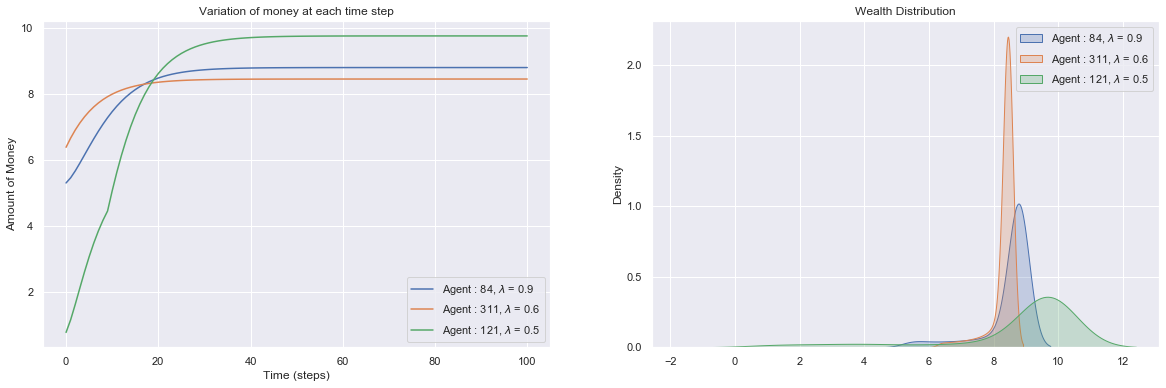

In [108]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)

for i in range(3):
    agent = random.randint(0,N-1)
    time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
    money = (data.loc[data['AgentID']==agent, 'k_t'].reset_index(drop = True)).to_numpy()
    lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]
    ax1.plot(time,money, label = "Agent : {}, $\lambda$ = {}".format(agent,lamda))
    sns.kdeplot(money, fill =True, label =  "Agent : {}, $\lambda$ = {}".format(agent,lamda), ax = ax2)
    
ax2.set_title("Wealth Distribution")
ax1.set_title("Variation of money at each time step")
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
ax1.legend()
ax2.legend()
plt.savefig(file + "\WealthDistribution_Comparison4")

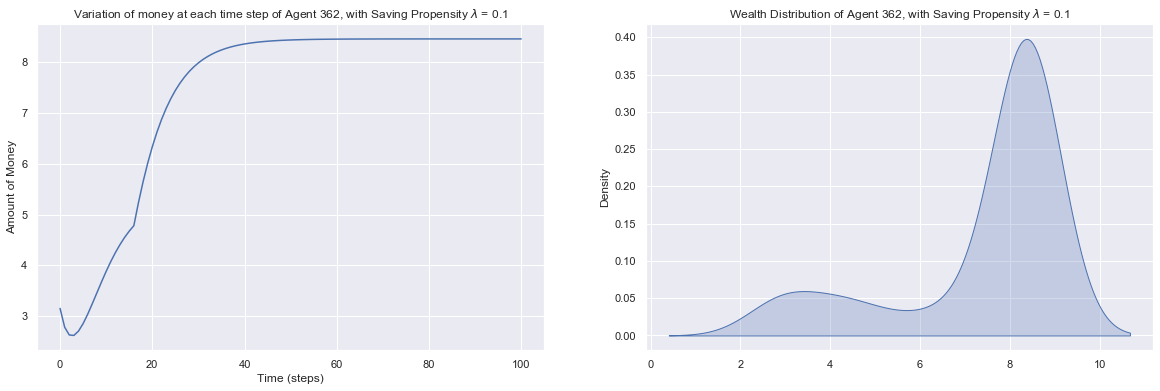

In [105]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)

agent = random.randint(0,N-1)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'k_t'].reset_index(drop = True)).to_numpy()
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]
ax1.plot(time,money, label = "Agent : {}, $\lambda$ = {}".format(agent,lamda))
sns.kdeplot(money, fill =True, label =  "Agent : {}, $\lambda$ = {}".format(agent,lamda), ax = ax2)
    
ax2.set_title("Wealth Distribution of Agent {}, with Saving Propensity $\lambda$ = {}".format(agent,lamda))
ax1.set_title("Variation of money at each time step of Agent {}, with Saving Propensity $\lambda$ = {}".format(agent,lamda))
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
plt.savefig(file + "\WealthDistribution_Agent{}".format(agent))

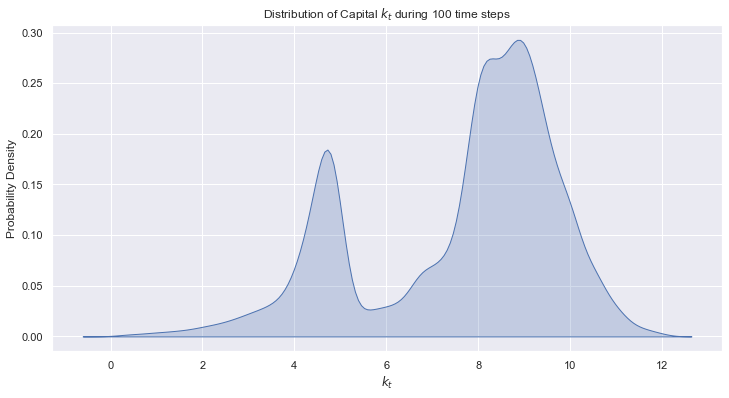

In [111]:
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data.k_t, fill = True)
plt.xlabel("$k_t$")
plt.ylabel("Probability Density")
plt.title("Distribution of Capital $k_t$ during {} time steps".format(steps)) 
plt.savefig(file + "\kdeplot_k");

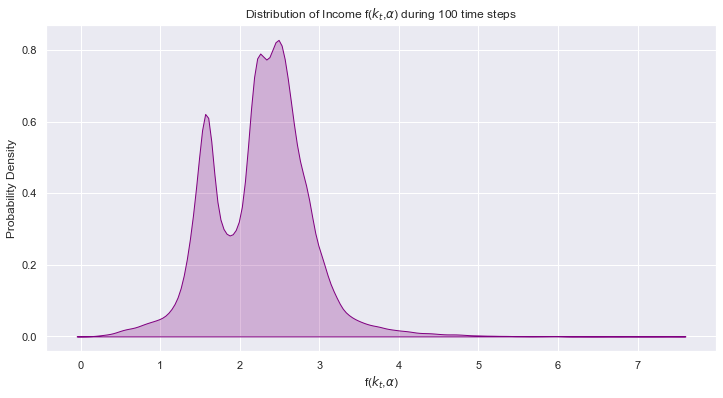

In [124]:
sns.set(rc={'figure.figsize':(12,6)})
sns.kdeplot(data.income, fill = True, color = 'purple')
plt.xlabel("f($k_t$,$\\alpha$)")
plt.ylabel("Probability Density")
plt.title("Distribution of Income f($k_t$,$\\alpha$) during {} time steps".format(steps)) 
plt.savefig(file + "\kdeplot_income");

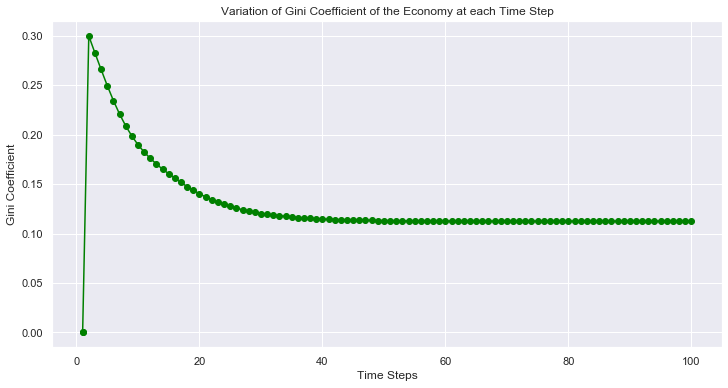

In [118]:
plt.plot(np.linspace(1,steps,steps+1, dtype = 'int'), model_df['Gini'], '-o', color = 'green')
plt.xlabel("Time Steps")
plt.ylabel("Gini Coefficient")
plt.title("Variation of Gini Coefficient of the Economy at each Time Step")
plt.savefig(file+"\Gini")

[0.         1.19816201 1.11441962 1.08552296 1.09787325 1.13812279
 1.19498753 1.25950287 1.32591529 1.39045024 1.45066588 1.50529528
 1.55393418 1.59661634 1.6337047  1.66558238 1.69282589 1.71596103
 1.8070983  1.88556894 1.95300711 2.01087678 2.06048433 2.1029744
 2.13934734 2.17047153 2.19709579 2.21986548 2.23933562 2.25598215
 2.2702138  2.28237998 2.29278004 2.3016701  2.30926924 2.31576485
 2.32131714 2.32606309 2.33011979 2.33358734 2.3365513  2.33908482
 2.34125041 2.34310151 2.34468379 2.3460363  2.3471924  2.34818063
 2.34902535 2.3497474  2.35036461 2.3508922  2.35134317 2.35172867
 2.35205818 2.35233985 2.35258062 2.35278643 2.35296235 2.35311273
 2.35324128 2.35335116 2.35344508 2.35352537 2.353594   2.35365266
 2.35370281 2.35374568 2.35378232 2.35381364 2.35384041 2.3538633
 2.35388286 2.35389958 2.35391387 2.35392609 2.35393654 2.35394546
 2.3539531  2.35395962 2.3539652  2.35396996 2.35397404 2.35397752
 2.3539805  2.35398304 2.35398522 2.35398708 2.35398867 2.353990

(0.7806694336843192, 9.76063458858338)

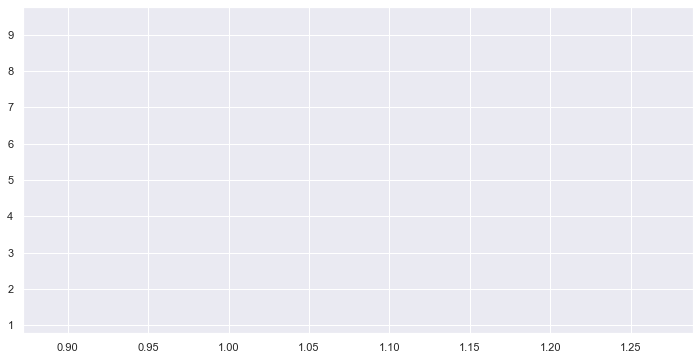

In [122]:
agent = random.randint(0,N-1)
H = (data.loc[data['AgentID']==agent, 'H'].reset_index(drop = True)).to_numpy()
print(H)
plt.xlim(min(alpha), max(alpha))
plt.ylim(min(money), max(money))